## IV. SPECTRAL ESTIMATION <br />

<div style="text-align:justify;text-indent:15px;"> Frequency-domain characteristics of acoustic signals carry a lot of information, and guitar sounds are no exception. For the fingering estimation task, and more precisely to estimate the partials of a guitar tone accurately, we need to delve into the realm of spectrum estimation. We took a look at different methods, usually referred to as subspace methods, and decided to focus on the popular MUSIC (MUltiple SIgnal Classification) algorithm. This will serve as a tool for the next (and central) step: inharmonicity estimation. </div>

### IV.I MUSIC <br />

<div style="text-aling:justified;">We first need to make some assumptions: </div>

- The recorded audio signal consists of the desired guitar sound - a harmonic signal - corrupted by some additive white noise of fixed variance $\sigma_w^{2}$. In mathematical terms, we consider the random process

\begin{equation}
    X[n] = \sum_{i = 1}^{p} A_i e^{j \omega_i n} + W[n]
\end{equation}

- The autocorrelation matrix $R_x$ of our process is of the form $R_x = R_s + R_n$, where $R_s$ and $R_n$ are the signal and noise correlation matrices, respectively. This directly comes from the underlying autocorrelation function structure: 
<br /><br />

\begin{equation}
    r_x[k] = \sum_{i = 1}^{p} P_i e^{j \omega_i k} + \sigma_w^{2} \delta [k]
\end{equation}

<br /><div style="text-align:justify;"> MUSIC is based on the decomposition of the correlation matrix $R_x$ into two orthogonal subspaces ([3]). Typically, we first extract the $M$ eigenpairs $\{(\lambda_i, \textbf{v}_i)\}_{i=1}^{M}$ from the estimated autocorrelation matrix, and sort them in decreasing order. The $p$ signal eigenvectors correspond to the $p$ largest eigenvalues, while the remaining $M - p$ noise eigenvectors are associated to the other $M - p$ eigenvalues (ideally equal to the noise variance $\sigma_w^2$). The two classical variations of the MUSIC algorithm are the following: </div>

- The first alternative (that we will refer to as regular MUSIC) is to compute a frequency estimation function $\hat{P}(e^{j \omega})$, that has poles or peaks (large magnitude) at the desired frequencies:

\begin{equation}
    \hat{P}(e^{j \omega}) = \frac{1}{\sum_{i=p+1}^{M} |V_i(e^{j \omega})|^2}
\end{equation}

- The second alternative (root MUSIC) is done as follows: the estimated frequencies are obtained as the angles/phases of the $p$ roots of the polynomial $D(z)$ closest to the unit circle, where

\begin{equation}
    D(z) = \sum_{i=p+1}^{M} V_i(z) V^{*}_i(1/z^{*})
\end{equation}

<br /><div style="text-align:justify;"> In the sequel, we will use the first version of the MUSIC algorithm (regular MUSIC). We first try our implementation on a toy example, and then adapt it to our context (first, on our simple model output with the string motion, and then on a real recording). </div>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import sounddevice as sd

from string_model import *
from pitch_estimation import *
from MUSIC import *

### IV.II A toy example <br />

<div style="text-align:justify;"> We first try our implementation of regular MUSIC on a toy example. Note that to adapt our first assumption above to the case of real-valued signals (as will be the case for real recordings), we need to take $p$ as twice the presumed number of sinusoids. </div>

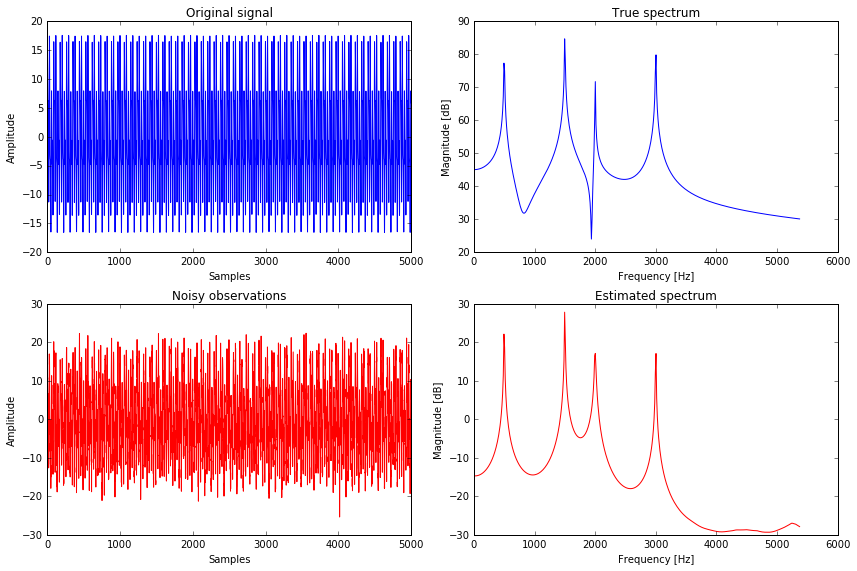

In [2]:
# MUSIC parameters
p = 8
M = 50
precision_autocorr = 10000
NFFT = 4096

# Simulation parameters
f_samp = 44100
t = np.arange(0.0, 2.0, 1/f_samp)

# amplitudes, frequencies, random initial phases, noise power
A = np.array([5, 10, 2, 6])
f = np.array([500, 1500, 2000, 3000])
theta = 2*np.pi*np.random.rand(p)
noise_var = 5

# original signal: simulated "guitar sound" (sum of p/2 sinusoids or p complex exponentials)
guitar_sound = np.imag(A[0] * np.exp(1j*(2*np.pi*f[0]*t + theta[0])) + A[1] * np.exp(1j*(2*np.pi*f[1]*t + theta[1]))\
    + A[2] * np.exp(1j*(2*np.pi*f[2]*t + theta[2])) + A[3] * np.exp(1j*(2*np.pi*f[3]*t + theta[3])))

# observed signal: "guitar sound" corrupted by some additive white noise
x = guitar_sound + np.sqrt(noise_var) * np.random.randn(guitar_sound.shape[0])

# estimate the power spectrum using regular MUSIC
estimated_spectrum = regular_music(x, p, M, precision_autocorr, NFFT)

# plots & visualization
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax1.plot(guitar_sound[0:5000])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original signal')

ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
ax2.plot(x[0:5000], 'r')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Noisy observations')

ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax3.plot(np.arange(0, 500)*f_samp/NFFT, 20*np.log10(np.abs(np.fft.fft(guitar_sound, NFFT))[0:500]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('True spectrum')

ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)
ax4.plot(np.arange(0, 500)*f_samp/NFFT, estimated_spectrum[0:500], 'r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Estimated spectrum')

plt.tight_layout()
plt.show()

### IV.II Testing the MUSIC algorithm on our simple model output <br />

<div style="text-align:justified;"> We now test our MUSIC implementation on the output of our simple model. Recall that the synthesized sound corresponds solely to the string motion at a fixed reference point. </div>

In [3]:
# string parameters
fundamental_freqs = np.array([82, 110, 147, 196, 247, 330])

string_diameters = (1/39.17) * np.array([47, 39, 30, 23, 14, 10]) * 1e-3
string_length = 0.64

p_steel = 7850
p_bronze = 8600
p_strings = p_bronze * (string_diameters/2)**2 * np.pi
p_strings[4:] = p_steel * (string_diameters[4:]/2)**2 * np.pi

tensions = 4*(string_length**2)*(fundamental_freqs**2)*p_strings
velocities = np.sqrt(tensions/p_strings)

# "playing" parameters
original_pluck = 1/5 + (np.random.rand() - 0.5)/30
init_displacement = 3e-3
max_mode = 10
modes_num = np.arange(1, max_mode + 1)

# simulation parameters
f_samp = 44100
T_samp = 1/f_samp
simulation_duration = 5.0
t = np.arange(0.0, simulation_duration, T_samp)

# MUSIC parameters
p = 2 * max_mode
M = 1000
precision_autocorr = 10000
NFFT = 4096

# noise power/variance
noise_var = .02

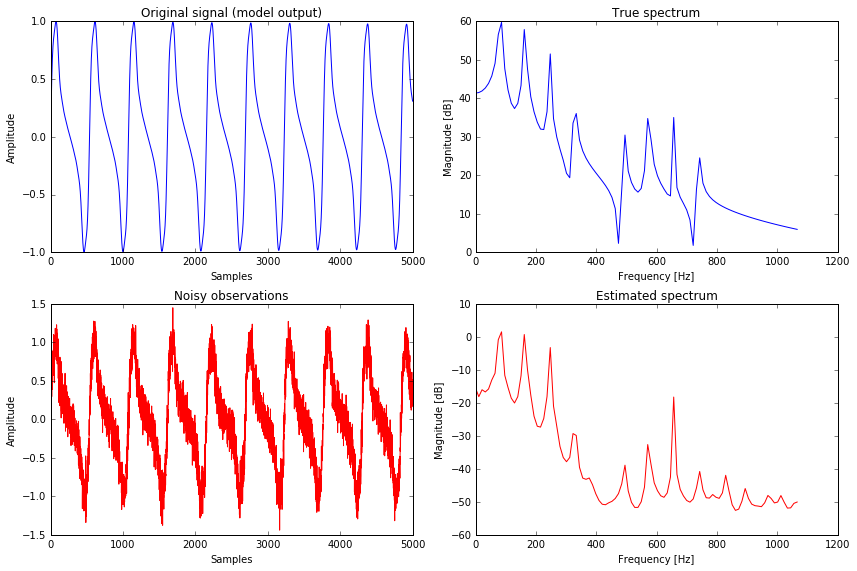

In [5]:
# note E2
string_num = 1
f0 = fundamental_freqs[string_num - 1]
c = velocities[string_num - 1]

# original signal (model output, i.e the string motion)
modes_amplitudes, string_motion = create_string_motion(modes_num, max_mode, init_displacement, original_pluck, \
                                                       string_length/5, f0, c, t)
string_motion /= max(string_motion)

# observed signal: string motion corrupted by some additive white noise
x = string_motion + np.sqrt(noise_var) * np.random.randn(string_motion.shape[0])

# estimate the power spectrum with regular MUSIC
estimated_spectrum = regular_music(x, p, M, precision_autocorr, NFFT)

# visualization
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax1.plot(string_motion[0:5000])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original signal (model output)')

ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
ax2.plot(x[0:5000], 'r')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Noisy observations')

ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax3.plot(np.arange(0, 100)*f_samp/NFFT, 20 * np.log10(np.abs(np.fft.fft(string_motion, NFFT))[0:100]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('True spectrum')

ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)
ax4.plot(np.arange(0, 100)*f_samp/NFFT, estimated_spectrum[0:100], 'r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Estimated spectrum')

plt.tight_layout()
plt.show()

### IV.III Testing the MUSIC algorithm on real recordings <br />

<div style="text-align:justified;"> We now test our MUSIC implementation on real recordings. We compare the estimated spectrum to the plain observed spectrum (raw FFT) and take a look at the estimated fundamental frequency and the other relatively strong peaks. </div>

In [6]:
# MUSIC parameters
p = 20
M = 1000
precision_autocorr = 10000
NFFT = 2**13

# real recording parameters
PATH_RECORDINGS = '../recordings/string_6/string_6_fret_0/'
file_name = 'string_6_fret_0_take_1.wav'

# read the recording from the folder
fs_recording, current_recording = wavfile.read(PATH_RECORDINGS + file_name)
y = current_recording/max(current_recording)

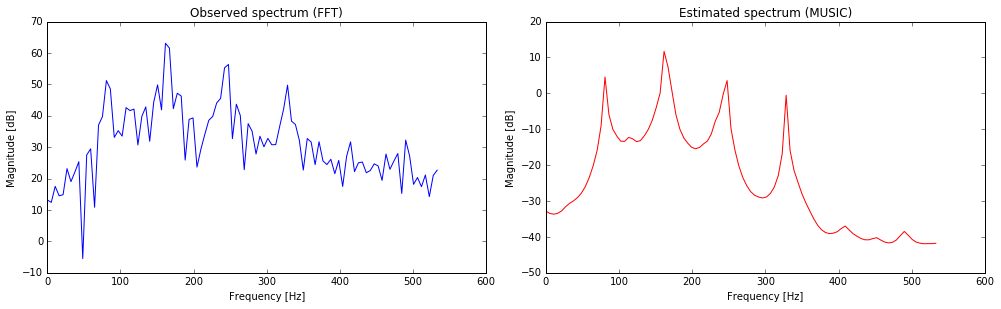

Estimated fundamental frequency [Hz]: 82.40

Other spectral peaks [Hz]:
[   80.74951172   113.04931641   161.49902344   247.63183594   328.38134766
   409.13085938   452.19726562   489.88037109   522.18017578   532.94677734
   576.01318359   656.76269531   737.51220703   802.11181641   845.17822266
   904.39453125   947.4609375    990.52734375  1033.59375   ]

Frequency ratios with the estimated fundamental:
[  0.9799698    1.37195772   1.9599396    3.00524073   3.98521053
   4.96518033   5.48783089   5.94515013   6.33713806   6.4678007
   6.99045126   7.97042106   8.95039086   9.7343667   10.25701727
  10.97566179  11.49831235  12.02096291  12.54361347]


In [7]:
# estimate the spectrum with regular MUSIC
estimated_spectrum = regular_music(y, p, M, precision_autocorr, NFFT)

# visualization
fig = plt.figure(figsize=(14, 8))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax1.plot(np.arange(0, 100)*f_samp/NFFT, 20 * np.log10(np.abs(np.fft.fft(y, NFFT))[0:100]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Observed spectrum (FFT)')

ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax2.plot(np.arange(0, 100)*f_samp/NFFT, estimated_spectrum[0:100], 'r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Estimated spectrum (MUSIC)')

plt.tight_layout()
plt.show()

# extract the fundamental frequency
fund_freq = estimate_fundamental(estimated_spectrum, fs_recording, NFFT, .05, 10)
print("Estimated fundamental frequency [Hz]: {f:.2f}".format(f=fund_freq))

# extract the spectral peaks from the estimated spectrum (relative maxima)
spectral_peaks = np.asarray([argrelmax(estimated_spectrum[0:200], axis=0, order=1)])
print("\nOther spectral peaks [Hz]:")
print(spectral_peaks[0,0,:] * f_samp/NFFT)

# show the frequency ratios of the peaks to the fundamental
print("\nFrequency ratios with the estimated fundamental:")
print((spectral_peaks[0,0,:] * f_samp/NFFT)/ fund_freq)

We can draw the following conclusions:


- MUSIC vs. "plain FFT": As we can see, the spectrum estimated through the MUSIC algorithm is much more meaningful than the plain FFT spectrum. The spectral peaks are much more visible and can be clearly distinguished.


- (In)harmonicity: In most cases, the frequency ratios of the spectral peaks to the fundamental are nearly integer numbers. However, we still observe a small inharmonicity (not perfect integer relations), something we will explore in depth in the next chapter.


- A strong second harmonic: In several recordings, the second harmonic appears much stronger than the true fundamental. This is quite surprising, since what we hear (the perceived pitch) corresponds to the first harmonic. It may be explained physiologically, as the human brain uses the relation between the harmonics to resolve the actual pitch. It seems to happen more frequently for the lower-pitched notes.


- Effect of the guitar body: While analyzing the estimated spectra, some unexpected peaks seemed to be persistent. For instance, two peaks around 100 and 200 Hz in all the recordings of the open high-E (330 Hz). This may be caused by the guitar body: maybe these are strong resonances of the guitar body!


- Parameters: The estimated spectrum is quite sensitive to the parameters used: the presumed number of harmonics, the size of the autocorrelation matrix we use, the number of samples used to compute the sample autocorrelation, and the frequency resolution. A fairly stable choice is p = 20, M = 1'000, 10'000 samples to compute the autocorrelation, and 8192 FFT points.